### Filter Neverworld 2 simulations 

In [2]:
I_want_dask = True

if I_want_dask: 
    from dask_gateway import Gateway
    gateway = Gateway()
    
    # close existing clusters
    open_clusters = gateway.list_clusters()
    print(list(open_clusters))
    
    flag_shut = False 
    
    if flag_shut: 
        if len(open_clusters)>0:
            for c in open_clusters:
                cluster = gateway.connect(c.name)
                cluster.shutdown()  
    
    options = gateway.cluster_options()
    
    #options.worker_memory = 16 # 24 works fine for long term mean, but seasonal needs a bit more
    # options.worker_cores = 8
    
    options.environment = dict(
        DASK_DISTRIBUTED__SCHEDULER__WORKER_SATURATION="1.0"
    )
    
    # Create a cluster with those options
    cluster = gateway.new_cluster(options)
    client = cluster.get_client()
    cluster.adapt(15, 40)
    #cluster.scale(10)
client

[]


<Client: 'tls://10.0.88.8:8786' processes=0 threads=0, memory=0 B>

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from xgcm import Grid
import gcm_filters as gcmf
import os
PERSISTENT_BUCKET = os.environ['PERSISTENT_BUCKET']
import dask.array as da

In [4]:
import gcsfs
fs = gcsfs.GCSFileSystem()
fs.ls(f'{PERSISTENT_BUCKET}/MOM6/NeverWorld2/R32')

['leap-persistent/dhruvbalwada/MOM6/NeverWorld2/R32/prog.zarr']

In [5]:
ds_NW2 = xr.open_zarr(f'{PERSISTENT_BUCKET}/MOM6/NeverWorld2/R32/prog.zarr',
                     decode_times=False)

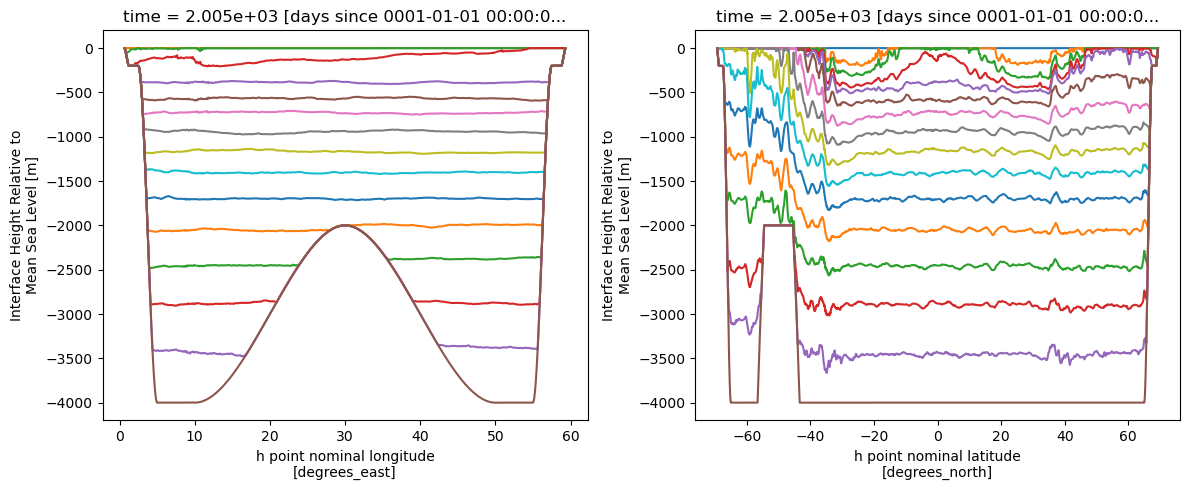

In [6]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
for i in range(0,16):
    ds_NW2.e.isel(time=0, zi=i).sel(yh=0, method='nearest').plot()

plt.subplot(122)
for i in range(0,16):
    ds_NW2.e.isel(time=0, zi=i).sel(xh=10, method='nearest').plot()

plt.tight_layout()

### Filtering 

In [7]:
## Create grid area element
coords = {'X': {'center': 'xh', 'outer': 'xq'},
            'Y': {'center': 'yh', 'outer': 'yq'},
            'Z': {'center': 'zl', 'outer': 'zi'} }

grid = Grid(ds_NW2, coords=coords, periodic=['X'])
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xh --> outer
  * outer    xq --> center
Y Axis (not periodic, boundary=None):
  * center   yh --> outer
  * outer    yq --> center
Z Axis (not periodic, boundary=None):
  * center   zl --> outer
  * outer    zi --> center

In [8]:
dx = 110e3 *np.cos(ds_NW2.yh*np.pi/180)* grid.diff(ds_NW2.xq,'X', boundary='extend') 
dy = 110e3* grid.diff(ds_NW2.yq,'Y', boundary='extend')
area_t = dy*dx

/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


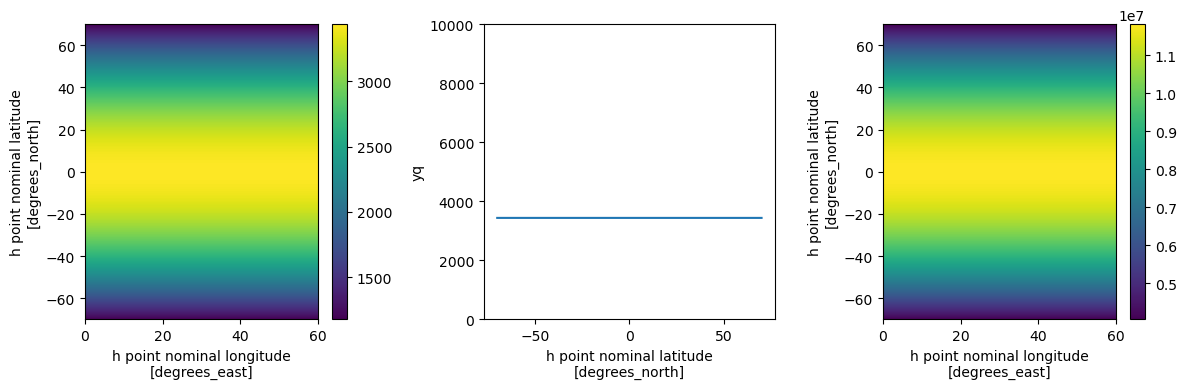

In [9]:
plt.figure(figsize=(12,4))
           
plt.subplot(131)
dx.plot()

plt.subplot(132)
dy.plot()
plt.ylim(0, 10e3)

plt.subplot(133) 
area_t.plot()

plt.tight_layout()

In [10]:
filter_scale = 96
dx_min = 1

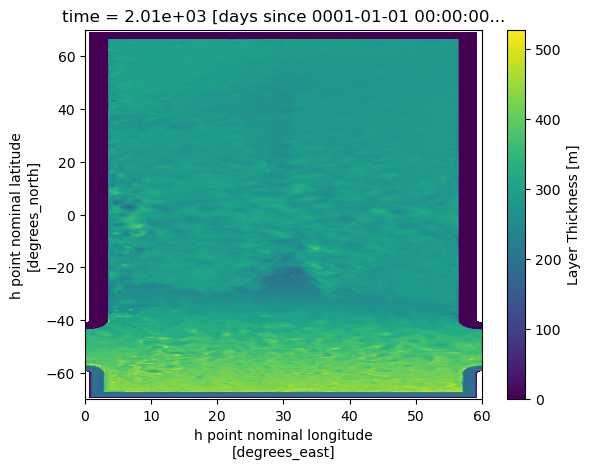

In [11]:
ds_NW2.h.isel(time=-1, zl=-6).plot()

In [13]:
hx = grid.interp(grid.diff(ds_NW2.h, 'X'), 'X')/ dx
hy = grid.interp(grid.diff(ds_NW2.h, 'Y', boundary='extend') , 'Y', boundary='extend')/dy
gradh = np.sqrt(hx**2 + hy**2)

/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in orde

In [14]:
gradh.load(); 

/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 65.71 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [15]:
h=ds_NW2.h
h.load(); 


In [16]:
e=ds_NW2.e
e.load(); 


In [17]:
v=ds_NW2.v
v.load(); 


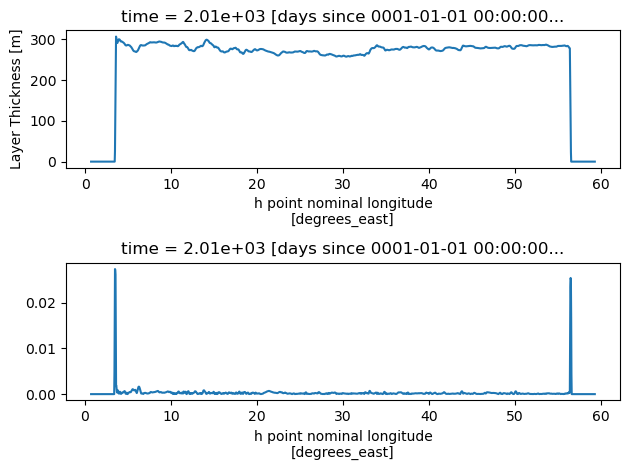

In [19]:
plt.subplot(211)
h.isel(time=-1, zl=-6).sel(yh=40, method='nearest').plot() 

plt.subplot(212)
gradh.isel(time=-1, zl=-6).sel(yh=40, method='nearest').plot() 

plt.tight_layout()

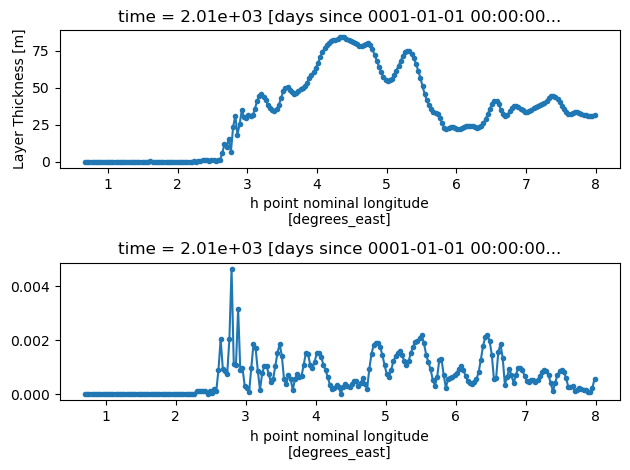

In [23]:
layer = 0
plt.subplot(211)
h.isel(time=-1, zl=layer).sel(yh=40, method='nearest').sel(xh=slice(0, 8)).plot(marker='.') 

plt.subplot(212)
gradh.isel(time=-1, zl=layer).sel(yh=40, method='nearest').sel(xh=slice(0, 8)).plot(marker='.') 

plt.tight_layout()

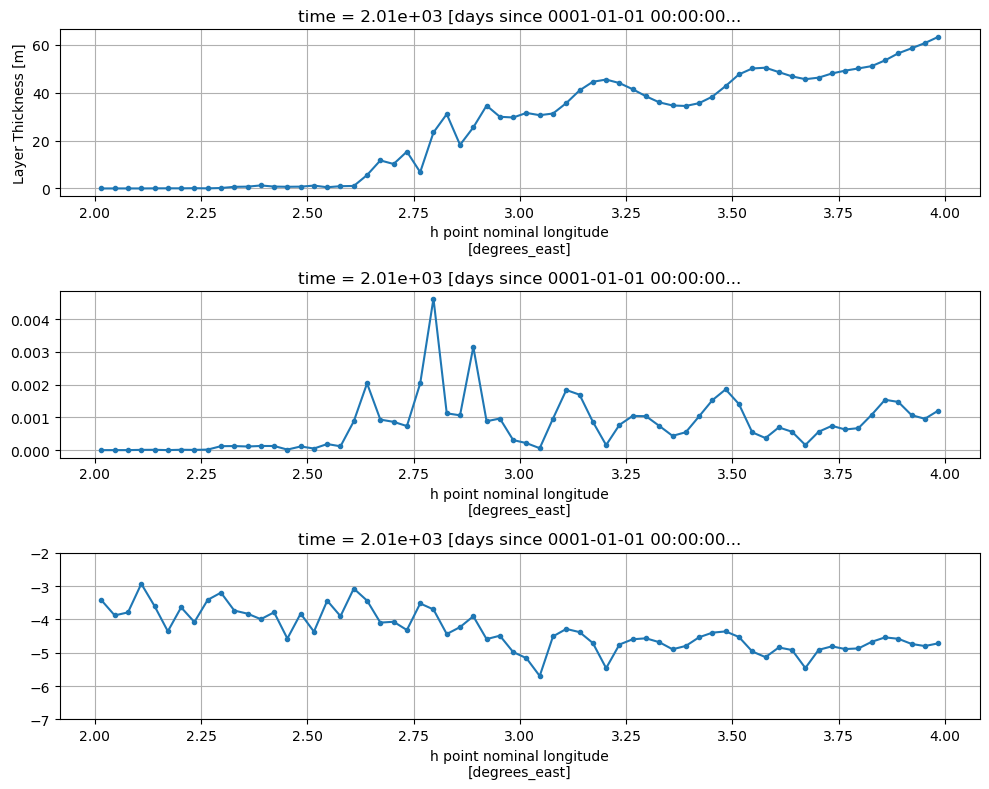

In [24]:
plt.figure(figsize=(10, 8))
layer = 0

plt.subplot(311)
h.isel(time=-1, zl=layer).sel(yh=40, method='nearest').sel(xh=slice(2, 4)).plot(marker='.') 
plt.grid()

plt.subplot(312)
gradh.isel(time=-1, zl=layer).sel(yh=40, method='nearest').sel(xh=slice(2, 4)).plot(marker='.') 
plt.grid()

plt.subplot(313)
np.log10(gradh/h).isel(time=-1, zl=layer).sel(yh=40, method='nearest').sel(xh=slice(2, 4)).plot(marker='.') 
plt.ylim(-7, -2)
plt.grid()

plt.tight_layout()

In [ ]:
(gradh/h).isel(time=0).plot(col='zl', col_wrap=3, vmax= 1e-5)

In [ ]:
(gradh/h).isel(time=0).plot(col='zl', col_wrap=3, robust=True)

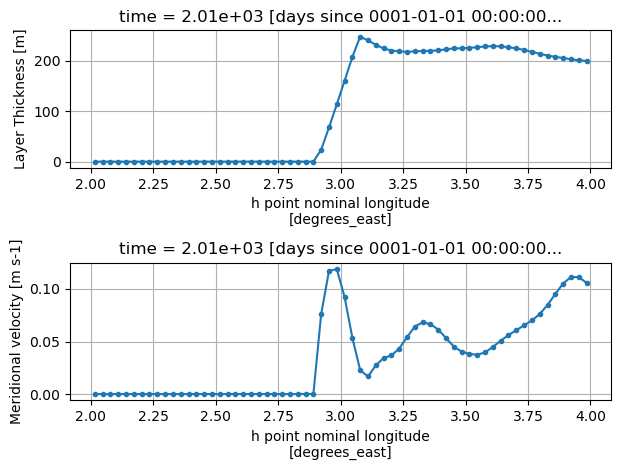

In [53]:
layer = -10
wid = slice(2,4)

plt.subplot(211)
h.isel(time=-1, zl=layer).sel(yh=40, method='nearest').sel(xh=wid).plot(marker='.') 
plt.grid()

plt.subplot(212)
v.isel(time=-1, zl=layer).sel(yq=40, method='nearest').sel(xh=wid).plot(marker='.') 
plt.grid()

plt.tight_layout()

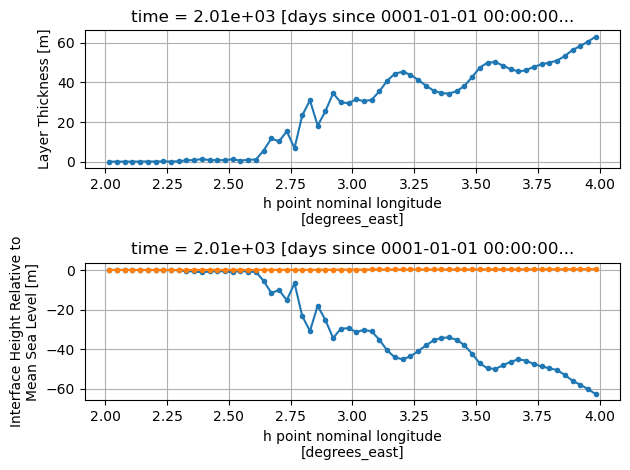

In [57]:
layer = 0
wid = slice(2,4)

plt.subplot(211)
h.isel(time=-1, zl=layer).sel(yh=40, method='nearest').sel(xh=wid).plot(marker='.') 
plt.grid()

plt.subplot(212)
e.isel(time=-1, zi=layer+1).sel(yh=40, method='nearest').sel(xh=wid).plot(marker='.') 
#e.isel(time=-1, zi=layer+1).sel(yh=40, method='nearest').sel(xh=wid).plot(marker='.') 
e.isel(time=-1, zi=layer).sel(yh=40, method='nearest').sel(xh=wid).plot(marker='.') 
plt.grid()

plt.tight_layout()

(array([8.152620e+05, 1.702400e+04, 1.433100e+04, 1.563860e+05,
        4.854500e+05, 5.300765e+06, 6.436690e+05, 6.849370e+05,
        2.399800e+05, 2.268000e+03]),
 array([1.00000001e-10, 5.27578239e+01, 1.05515648e+02, 1.58273468e+02,
        2.11031296e+02, 2.63789124e+02, 3.16546936e+02, 3.69304779e+02,
        4.22062592e+02, 4.74820435e+02, 5.27578247e+02]),
 <BarContainer object of 10 artists>)

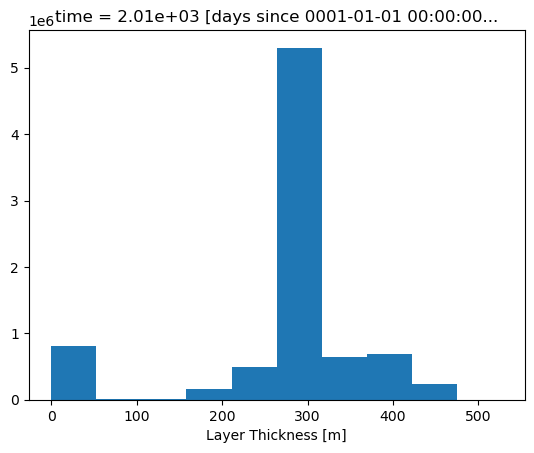

In [32]:
h.isel(time=-1, zl=-6).plot.hist()

(array([9.500000e+01, 9.500000e+01, 8.600000e+01, 8.000000e+01,
        9.600000e+01, 6.000000e+01, 6.900000e+01, 7.300000e+01,
        6.600000e+01, 9.600000e+01, 9.800000e+01, 9.400000e+01,
        7.800000e+01, 1.020000e+02, 1.250000e+02, 1.200000e+02,
        2.110000e+02, 3.220000e+02, 4.640000e+02, 1.273000e+03,
        3.037000e+03, 4.232000e+03, 5.868000e+03, 1.547900e+04,
        2.140800e+04, 3.129000e+04, 5.996700e+04, 1.270110e+05,
        2.808600e+05, 5.807060e+05, 1.048871e+06, 1.541811e+06,
        1.657545e+06, 1.168493e+06, 5.652900e+05, 2.345520e+05,
        9.089500e+04, 4.383300e+04, 3.202900e+04, 2.367500e+04,
        1.460600e+04, 2.599800e+04, 5.419000e+03, 1.126000e+03,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00]),
 array([-10. ,  -9.8,  -9.6,  -9.4,  -9.2,  -9. ,  -8.8,  -8.6,  -8.4,
         -8.2,  -8. ,  -7.8,  -7.6,  -7.4,  -7.2,  -7. ,  -6.8,  -6.6,
         -6.4,  -6.2,  -6. ,  -5.8,  -5.6,  -5.4,  -

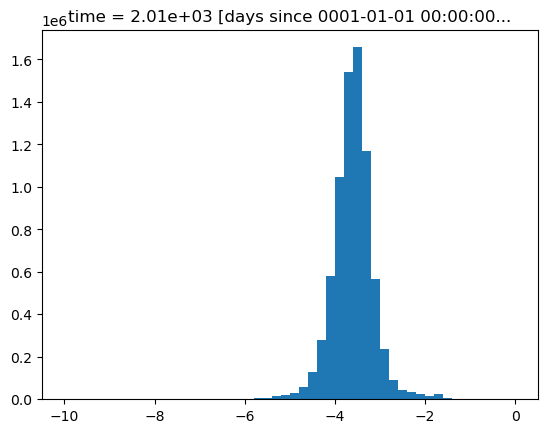

In [37]:
np.log10(gradh).isel(time=-1, zl=-6).plot.hist(bins=np.linspace(-10, 0, 51))

In [ ]:
gradh.isel(time=1, zl=-6).plot().

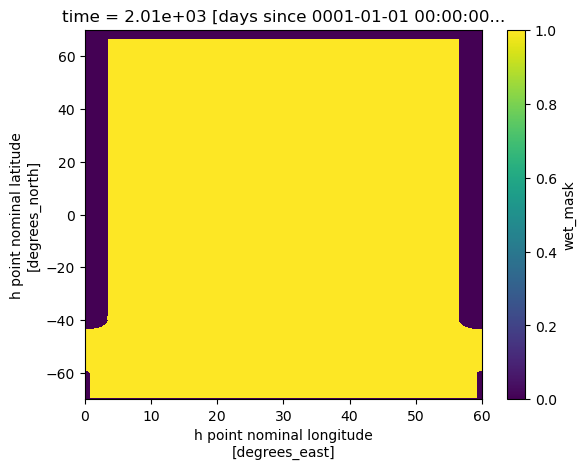

In [27]:
wet_mask_zl.isel(time=1, zl=-6).plot()

In [11]:
wet_mask_zl = (ds_NW2.h>1).astype('float32').rename('wet_mask')

In [14]:
wet_mask_zl.isel(time=1, zl=-6)

<xarray.DataArray 'wet_mask' (yh: 4480, xh: 1920)>
dask.array<getitem, shape=(4480, 1920), dtype=float32, chunksize=(4480, 1920), chunktype=numpy.ndarray>
Coordinates:
    time     float64 2.01e+03
  * xh       (xh) float64 0.01562 0.04688 0.07812 0.1094 ... 59.92 59.95 59.98
  * yh       (yh) float64 -69.98 -69.95 -69.92 -69.89 ... 69.92 69.95 69.98
    zl       float64 1.027e+03

In [12]:
# Assuming you have a 4D Dask array of shape (2, 15, 4480, 1920)
original_shape = (2, 15, 4480, 1920)
#dask_array = da.zeros(original_shape, chunks=(1, 1, 4480, 1920))  # Create a 4D Dask array of zeros
dask_array = wet_mask_zl.data

# Append one more index along the second dimension with zeros
new_shape = (2, 1, 4480, 1920)
zeros_array = da.zeros(new_shape, dtype=dask_array.dtype)  # Create a 3D Dask array of zeros with the new shape

# Concatenate the original Dask array with the zeros array along the second dimension
concatenated_array = da.concatenate([dask_array, zeros_array], axis=1)

# Check the shape of the concatenated array
print(concatenated_array.shape)

(2, 16, 4480, 1920)


In [11]:
wet_mask_zi = xr.DataArray(concatenated_array, dims=ds_NW2.e.dims, coords=ds_NW2.e.coords)

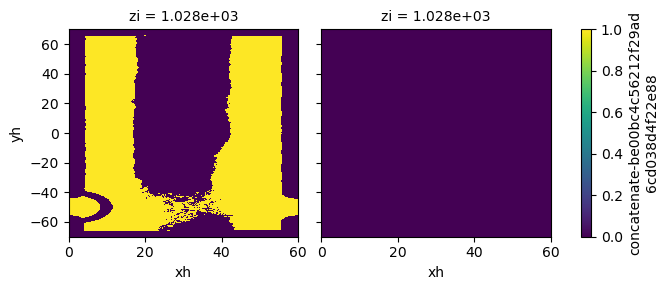

In [12]:
wet_mask_zi.isel(time=0, zi=slice(-2, None)).plot(col='zi')

In [13]:
filter_C = gcmf.Filter(filter_scale= filter_scale,  
                     dx_min = dx_min, 
                     filter_shape=gcmf.FilterShape.GAUSSIAN,
                     grid_type=gcmf.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
                     grid_vars = {'area':area_t,'wet_mask': wet_mask_zl})

In [14]:
filter_C

Filter(filter_scale=96, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=106, grid_type=<GridType.REGULAR_WITH_LAND_AREA_WEIGHTED: 4>)

In [15]:
filter_C_zi = gcmf.Filter(filter_scale= filter_scale,  
                     dx_min = dx_min, 
                     filter_shape=gcmf.FilterShape.GAUSSIAN,
                     grid_type=gcmf.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
                     grid_vars = {'area':area_t,'wet_mask': wet_mask_zi})

In [16]:
ds_filt = xr.Dataset() 
#ds_filt['h'] = filter_C.apply(ds_NW2.h, dims=['yh','xh']).rename('h') # old way to define h

In [17]:
ds_filt['ebar'] = filter_C_zi.apply(ds_NW2.e, dims=['yh','xh']).rename('e')

In [18]:
ds_filt['hbar'] = -grid.diff(ds_filt['ebar'].chunk({'zi':-1}), 'Z') # minus sign because of the order of differencing. 

/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [19]:
u_c = grid.interp(ds_NW2.u.fillna(0), 'X')
v_c = grid.interp(ds_NW2.v.fillna(0), 'Y')

/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [20]:
ds_filt['ubar'] = filter_C.apply(u_c, dims=['yh','xh']).rename('u')
ds_filt['vbar'] = filter_C.apply(v_c, dims=['yh','xh']).rename('v')

ds_filt['ubar_hbar'] = ds_filt['ubar']*ds_filt['hbar']
ds_filt['vbar_hbar'] = ds_filt['vbar']*ds_filt['hbar']
#ds_filt['uh'] = ds_NW2.h*u_c
#ds_filt['vh'] = ds_NW2.h*v_c

#ds_filt['ubar_hbar'] = (ds_filt.h*ds_filt.u)
#ds_filt['vbar_hbar'] = (ds_filt.h*ds_filt.v)

#ds_filt['ubar_hbar']

In [21]:
from xgcm import as_grid_ufunc

@as_grid_ufunc("(Z:center),(Z:outer)->(Z:center)")
def multiply_upper(u, e): 
    return u * e[...,0:-1]

@as_grid_ufunc("(Z:center),(Z:outer)->(Z:center)")
def multiply_lower(u, e): 
    return u * e[...,1:None]

In [22]:
@as_grid_ufunc("(Z:center)->(Z:outer)")
def upward_sum(a):

    temp_zeros = np.zeros_like(a[...,0])[..., np.newaxis]
    
    #temp = np.flip(np.append([temp_zeros], np.cumsum(np.flip(a, axis=-1), axis=-1), axis=-1), axis=-1)
    temp = np.append(np.flip(np.cumsum(np.flip(a, axis=-1), axis=-1), axis=-1), temp_zeros, axis=-1)
    return temp

In [23]:
## U 
ueU = multiply_upper(grid, 
                      u_c.chunk({'zl':-1}), 
                      ds_NW2.e.chunk({'zi':-1}), 
                      axis=[['Z'],['Z']],
                      dask='parallelized'
                     )
ueD = multiply_lower(grid, 
                      u_c.chunk({'zl':-1}), 
                      ds_NW2.e.chunk({'zi':-1}), 
                      axis=[['Z'],['Z']],
                      dask='parallelized'
                     )

ueU_bar = filter_C.apply(ueU, dims=['yh','xh'])
ueD_bar = filter_C.apply(ueD, dims=['yh','xh'])

ubar_eD = multiply_lower(grid, 
                      ds_filt.ubar.chunk({'zl':-1}), 
                      ds_NW2.e.chunk({'zi':-1}), 
                      axis=[['Z'],['Z']],
                      dask='parallelized'
                     )

## V
veU = multiply_upper(grid, 
                      v_c.chunk({'zl':-1}), 
                      ds_NW2.e.chunk({'zi':-1}), 
                      axis=[['Z'],['Z']],
                      dask='parallelized'
                     )
veD = multiply_lower(grid, 
                      v_c.chunk({'zl':-1}), 
                      ds_NW2.e.chunk({'zi':-1}), 
                      axis=[['Z'],['Z']],
                      dask='parallelized'
                     )

veU_bar = filter_C.apply(veU, dims=['yh','xh'])
veD_bar = filter_C.apply(veD, dims=['yh','xh'])

vbar_eD = multiply_lower(grid, 
                      ds_filt.vbar.chunk({'zl':-1}), 
                      ds_NW2.e.chunk({'zi':-1}), 
                      axis=[['Z'],['Z']],
                      dask='parallelized'
                     )

/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in orde

In [24]:
ueD_bar_updated = ueD_bar.copy()
veD_bar_updated = veD_bar.copy()

In [25]:
mask_diff = -grid.diff(wet_mask_zi.chunk({'zi':-1}), 'Z')

/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [26]:
ueD_bar_updated = ueD_bar_updated.where(mask_diff<0.1, ubar_eD) 
veD_bar_updated = veD_bar_updated.where(mask_diff<0.1, vbar_eD) 
#Returns elements from ‘DataArray’, where ‘cond’ is True, otherwise fill in ‘other’.

In [27]:
# uh_bar

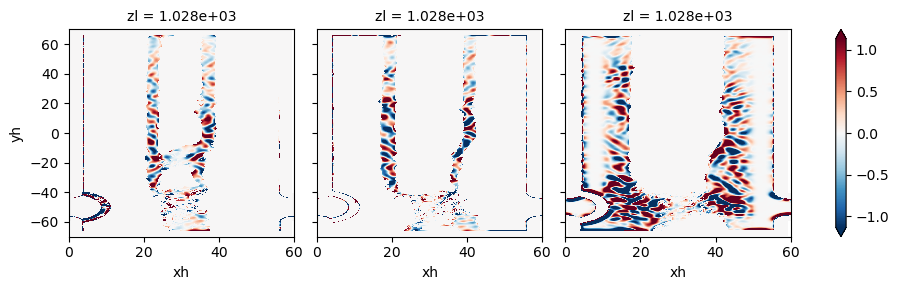

In [28]:
(ueD_bar_updated - ueD_bar).isel(zl=slice(-3, None), time=1).plot(col='zl', robust=True)

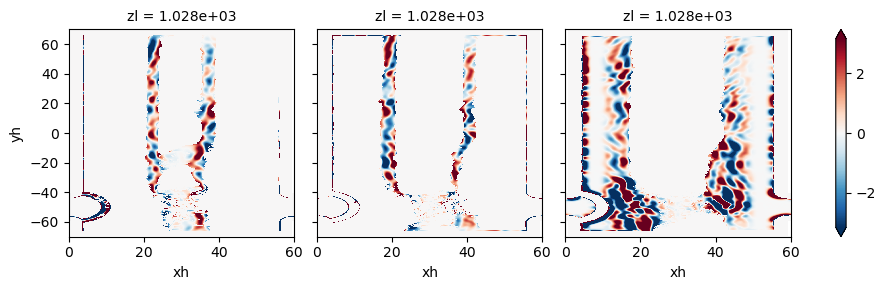

In [29]:
(veD_bar_updated - veD_bar).isel(zl=slice(-3, None), time=1).plot(col='zl', robust=True)

In [30]:
#ds_filt['hbar'] = -grid.diff(ds_filt['ebar'].chunk({'zi':-1}), 'Z') # minus sign because of the order of differencing. 
ds_filt['uh_bar'] = ueU_bar - ueD_bar_updated
ds_filt['vh_bar'] = veU_bar - veD_bar_updated

In [31]:
ds_filt['uh_sg'] = ds_filt.uh_bar - ds_filt.ubar_hbar
ds_filt['vh_sg'] = ds_filt.vh_bar - ds_filt.vbar_hbar

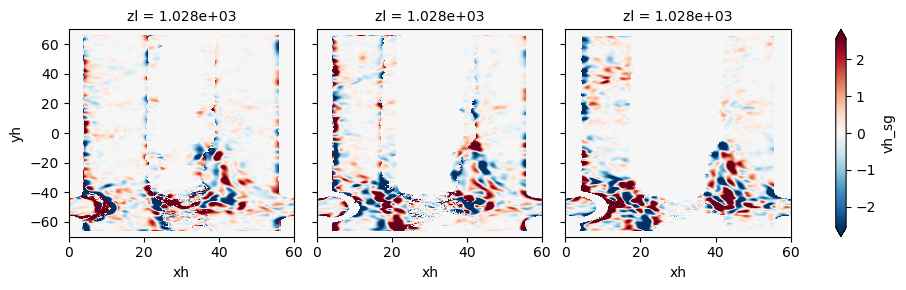

In [32]:
ds_filt['vh_sg'].isel(zl=slice(-3, None), time=1).plot(col='zl', robust=True)

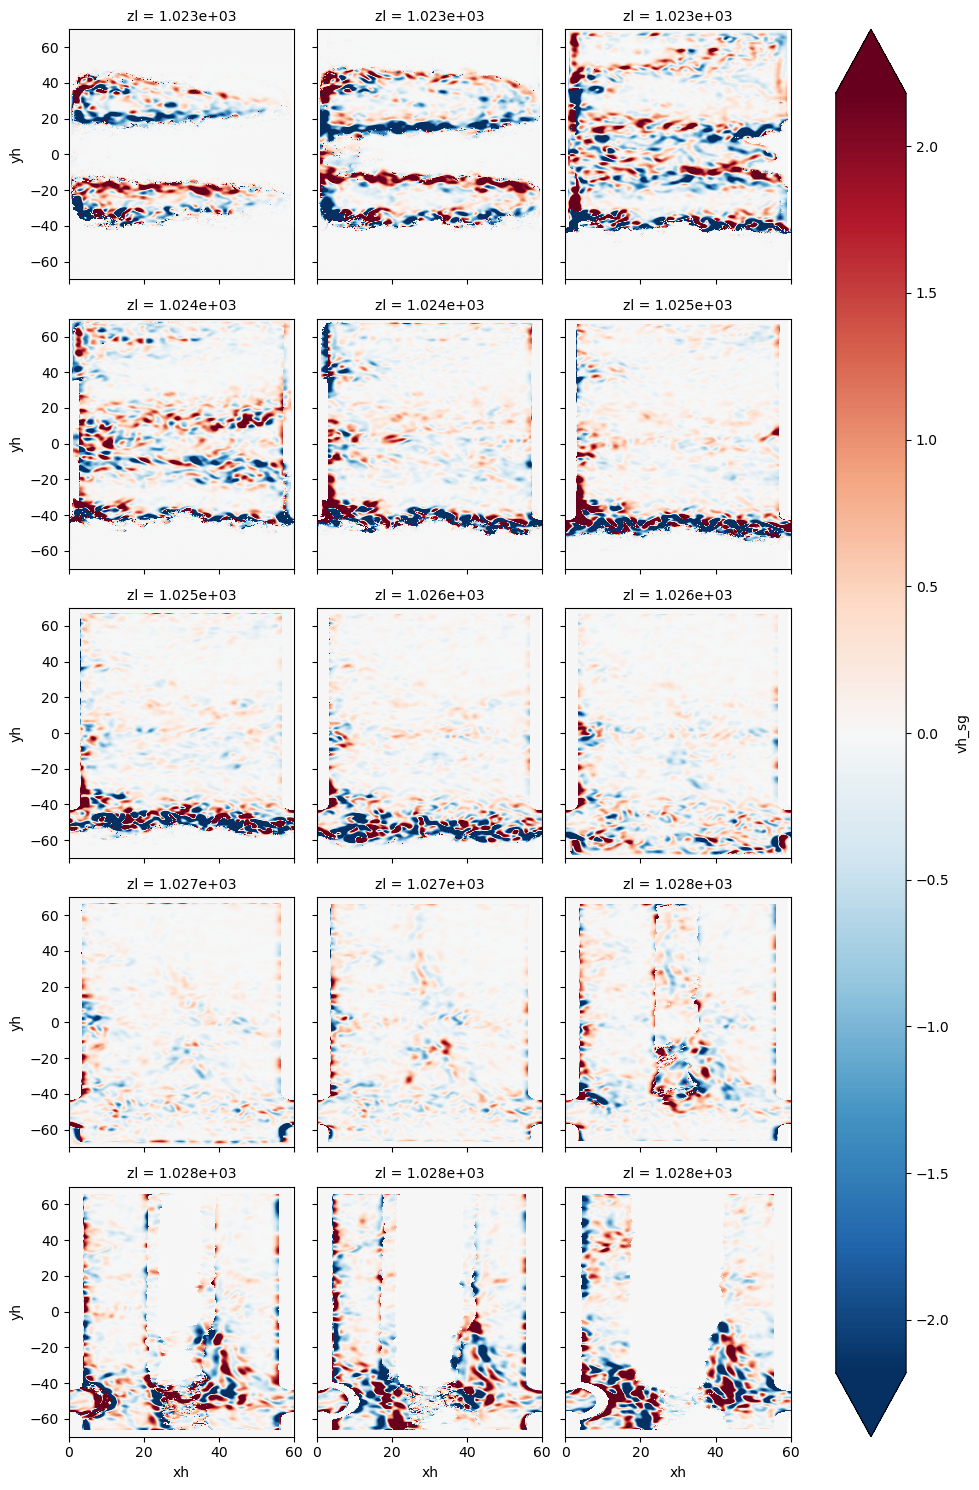

In [33]:
ds_filt['vh_sg'].isel(time=1).plot(col='zl', col_wrap=3, robust=True)

In [34]:
ds_filt['Psi_x'] = upward_sum(grid, ds_filt.uh_sg.chunk({'zl':-1}), axis=[['Z']],
                      dask='parallelized'
                     )
ds_filt['Psi_y'] = upward_sum(grid, ds_filt.vh_sg.chunk({'zl':-1}), axis=[['Z']],
                      dask='parallelized'
                     )

/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [35]:
ds_filt.load();

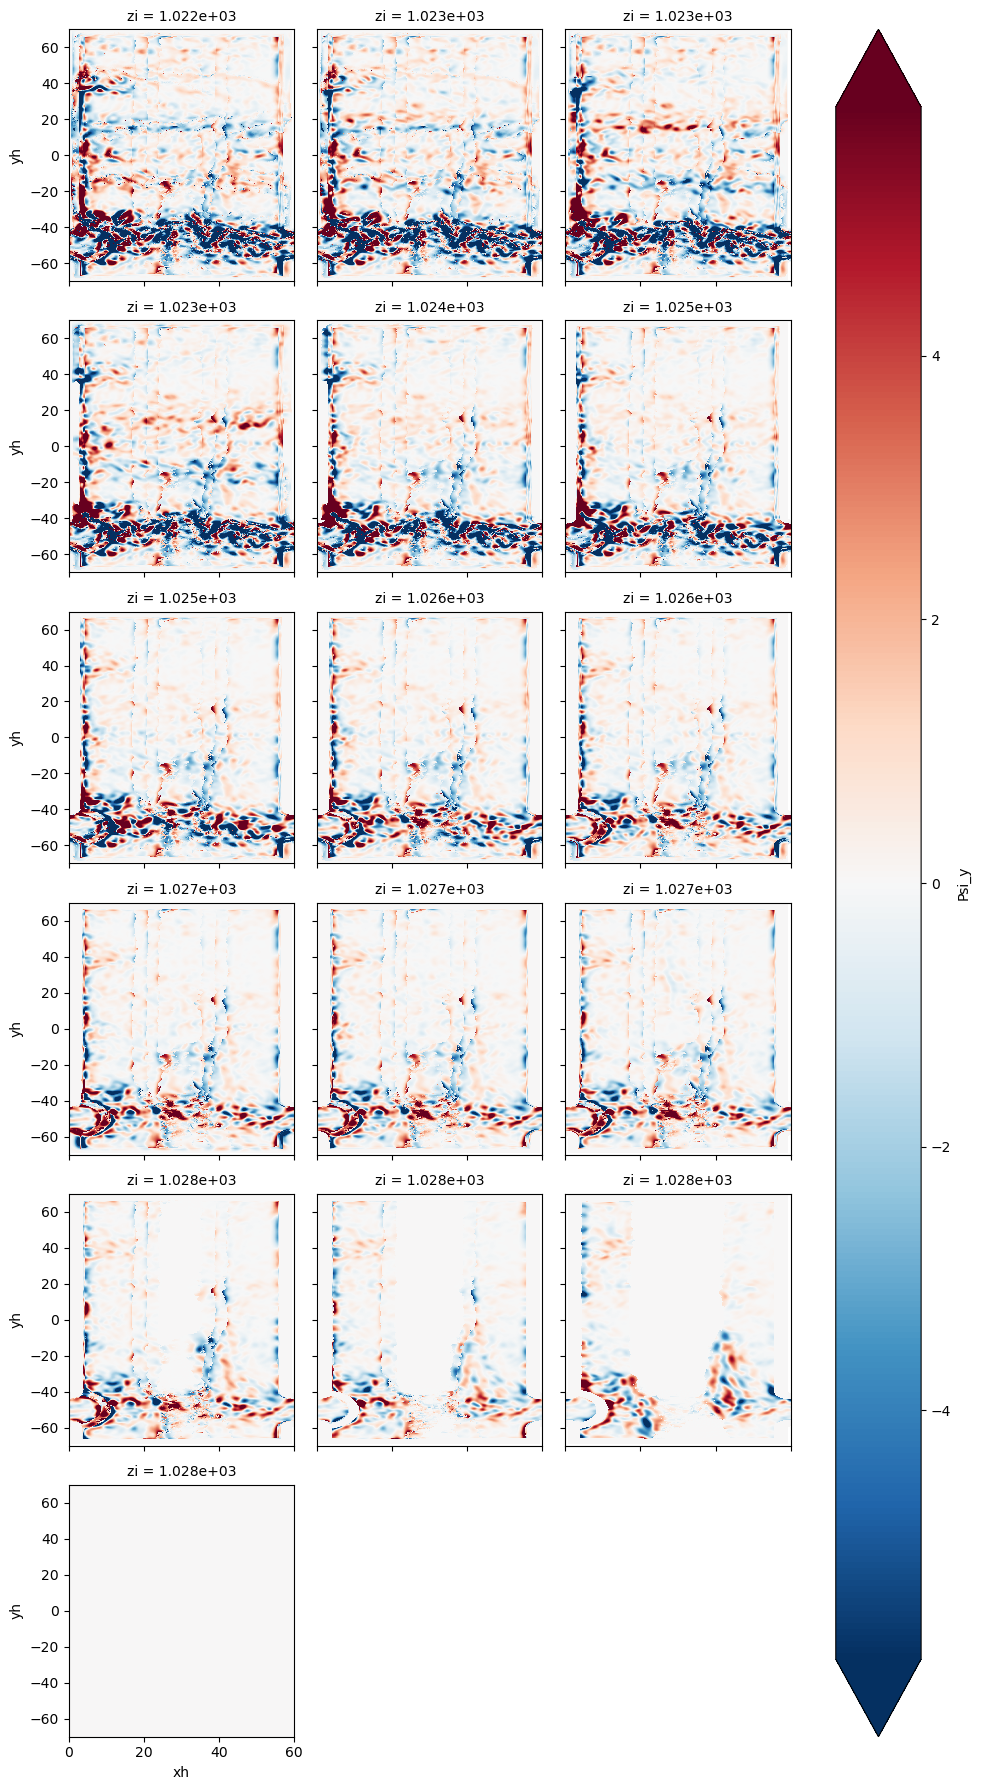

In [40]:
ds_filt.Psi_y.isel(time=0).plot(col='zi', col_wrap=3, robust=True)

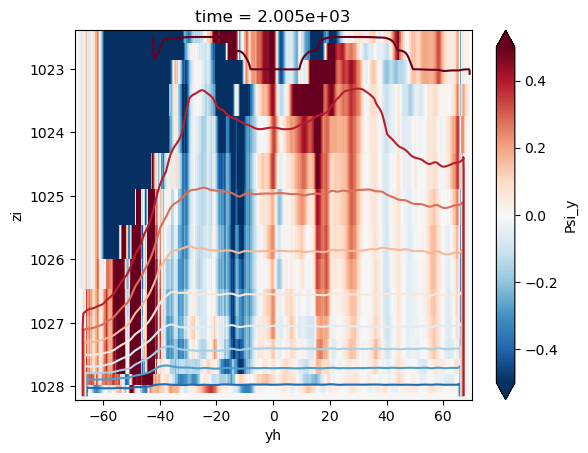

In [39]:
ds_filt.Psi_y.isel(time=0).sel(xh=slice(16, 50)).mean('xh').plot(y='zi', vmin=-0.5)
ds_filt.ebar.isel(time=0).sel(xh=slice(16, 50)).mean('xh').plot.contour(y='zi', robust=True, 
                                                                       levels=np.linspace(-1, -3000, 10))
plt.gca().invert_yaxis()

In [38]:
ds_filt.to_netcdf('temp_NW2_filt96.nc')